# Decision Tree Models

Decision trees are widely used models for classification and regression tasks. Essentially,
they learn a hierarchy of if/else questions, leading to a decision.

Imagine you want to distinguish between the following four animals: bears, hawks, penguins, and dolphins. Your goal is to get to the right answer by asking as few if/else
questions as possible. You might start off by asking whether the animal has feathers, a question that narrows down your possible animals to just two. If the answer is “yes,”
you can ask another question that could help you distinguish between hawks and penguins. 

For example, you could ask whether the animal can fly. If the animal doesn’t have feathers, your possible animal choices are dolphins and bears, and you
will need to ask a question to distinguish between these two animals—for example, asking whether the animal has fins.

This series of questions can be expressed as a decision tree, as shown in the following figure.

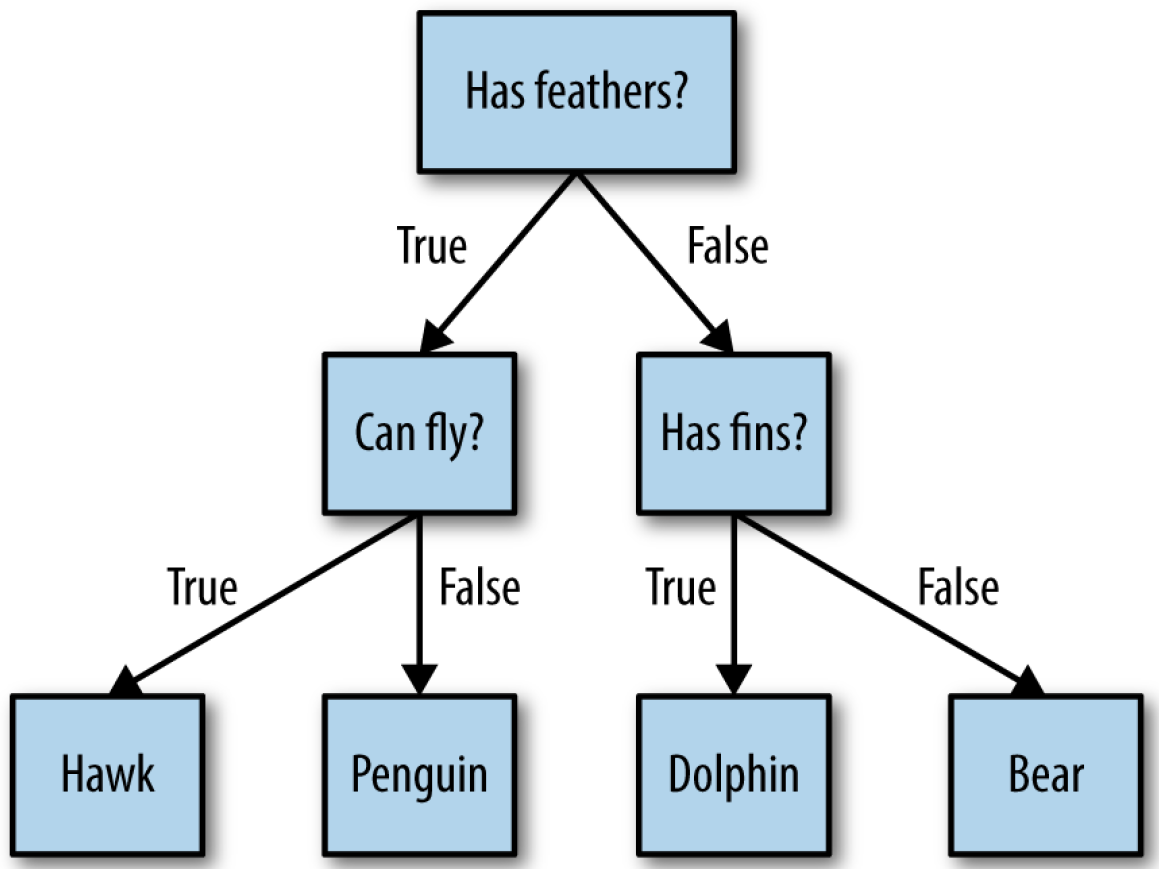

In [1]:
from IPython.display import Image
Image(filename='files/Fig1.png',width = "600",height = "300")

In this illustration, each node in the tree either represents a question or a terminal
node (also called a leaf) that contains the answer. The edges connect the answers to a
question with the next question you would ask.

## Study the decision tree models and the parameters
As we discussed in the lecture, the decision tree models can fulfil both classification and regression tasks. In scikit-learn, the Class [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) implements the decision tree classification model and the class [DecisionTreeRegression](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor) implements the decision tree regression model.

### 0. Import modules

In [2]:
# Import the modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score, mean_squared_error

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor


import warnings
warnings.filterwarnings("ignore")

### 1. Explore the use of the classification tree models with categorical features
**Data preparation.** In this demo, we use the [Breast Cancer Data Set](https://archive.ics.uci.edu/ml/datasets/breast+cancer). This is one of three domains provided by the Oncology Institute that has repeatedly appeared in the machine learning literature. (See also lymphography and primary-tumor.) This data set includes 201 instances of one class and 85 instances of another class. The instances are described by 9 attributes, some of which are linear and some are nominal. The data set has missing values for some attributes. We need to use the [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer) class to handle the missing values by replacing the missing values with the frequentest item in that attribute.

In [3]:
# Load the dataset. Note that there are missing values (denoted as '?') in the dataset and we need to impute them.
missing_values = ["?"]
raw_data = pd.read_csv('files/breast-cancer.csv', na_values=missing_values)
print('Missing value count: \n', raw_data.isnull().sum())

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')
cancer_data = imputer.fit_transform(raw_data)

pd.DataFrame(data=cancer_data, columns=raw_data.columns).head()

Missing value count: 
 Class          0
age            0
menopause      0
tumor-size     0
inv-nodes      0
node-caps      8
deg-malig      0
breast         0
breast-quad    1
irradiat       0
dtype: int64


,Class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no


**Encoding categorical data.** As the features are categorical, we need to convert them into the numerical form for the model. We use the class [OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html#sklearn.preprocessing.OrdinalEncoder) to tranform each categorical feature value into an integer, and the class [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) to transform the target classess into integers. 

In [4]:
# Data pre-processing and preparation
# Firstly, we need to convert the date from being categorical to being numerical
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
enc_X = OrdinalEncoder()
enc_y = LabelEncoder()

# The first attribute is the target, while the rest attributes are the features
target_index=0
X = enc_X.fit_transform(cancer_data[:, 1:])
y = enc_y.fit_transform(cancer_data[:, target_index])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

**Train and explore the model.** Train the DecisionTreeClassifier model with the default parameter settings.

In [5]:
# Train a decision tree model for classification
clf_default = DecisionTreeClassifier(random_state=42)
clf_default.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

**Visualize the tree model**

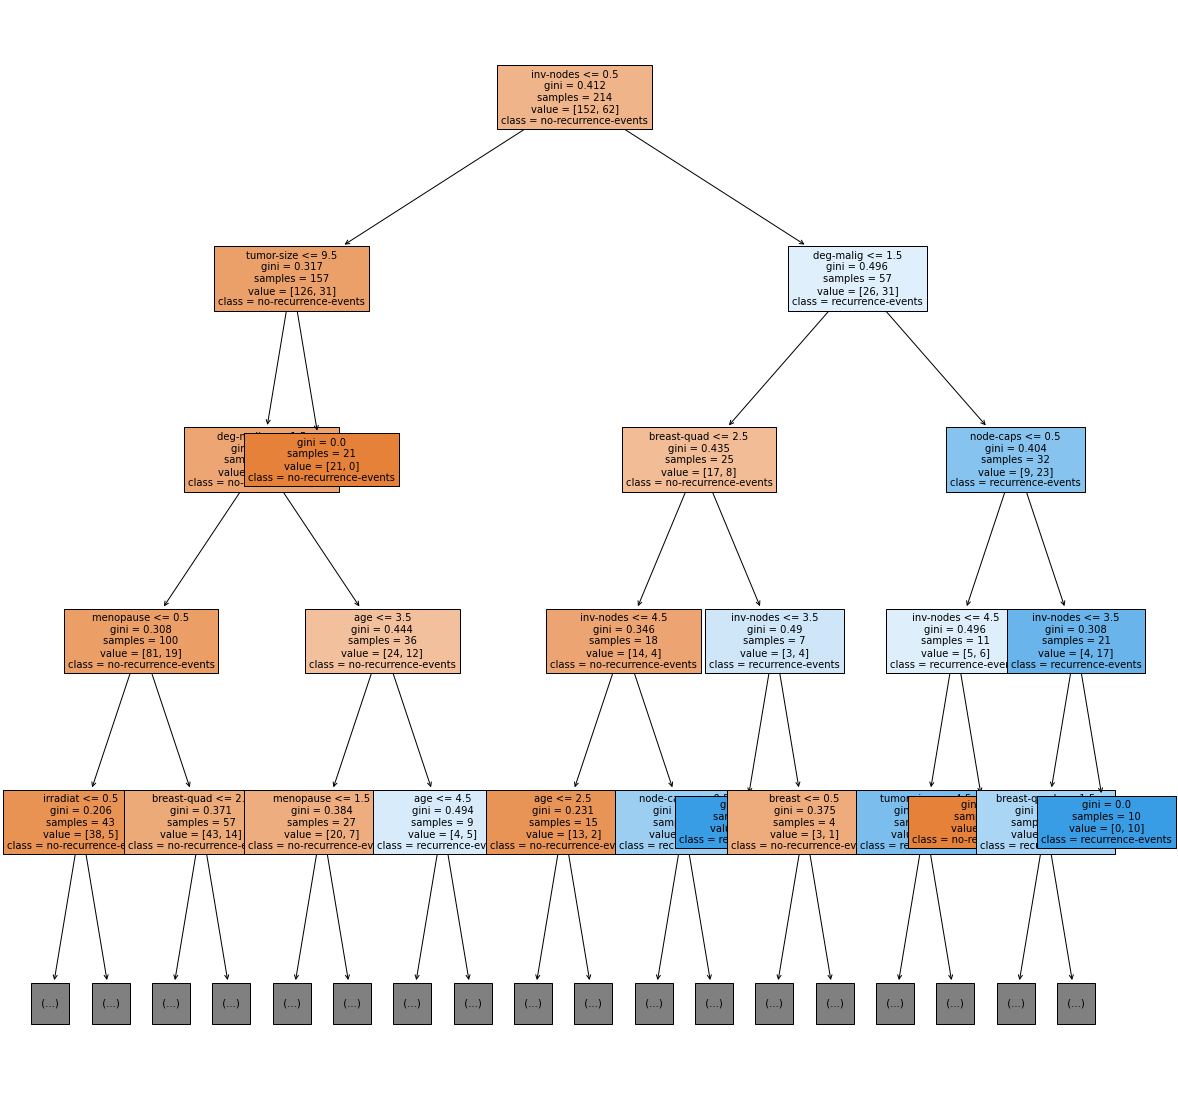

In [6]:
# Visualize the tree structure. Just show the first four layers
fig, ax = plt.subplots(figsize=(20, 20))
tree.plot_tree(clf_default, max_depth=4, filled=True, fontsize=10, 
               feature_names=raw_data.columns[1:], class_names=enc_y.classes_)
plt.show()

**Note that scikit-learn uses an optimised version of the CART algorithm; however, scikit-learn implementation does not support categorical variables for now.** So, it can be seen that the tree structure is binary and the categorical values are regarded as numerical attributes after the encoding. Extracting decision rules for CART decision tree structure might be difficult and meaningless. When using the OrdinalEncoder, we imposed an order on the categorical attribute values. An alternative way is to use [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder) to transform an original categorical attribute into multiple binary features. This will produce a larger search space and might lead to better peroformance. Interested students could try this encoding scheme for the features and see how much the performance can be improved.

**Analysing the decision tree.** The visualization of the tree provides a great in-depth view of how the algorithm makes predictions, and is a good example of a machine learning algorithm that is easily explained to nonexperts. However, even with a tree of depth four, as seen here, the tree can become a bit overwhelming. Deeper trees (a depth of 10 is not uncommon) are even harder to grasp. One method of inspecting the tree that may be helpful is to find out which path most of the data actually takes. The samples shown in each node in the above figure gives the number of samples in that node, while value provides the number of samples per class. 

**Evaluate the model.** We use accuracy score and confusion matrix as the performance indicators to evaluate the trained model against the testing data.

The testing accuracy is: 0.6389

[[39 16]
 [10  7]]


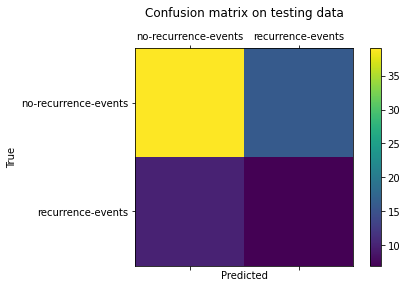

In [7]:
# Evaluate the trained model with the testing data
y_pred = clf_default.predict(X_test)

# The prediction accuracy
accuracy = accuracy_score(y_pred, y_test)
print('The testing accuracy is: %.4f\n' % accuracy)

# Show the confusion matrix
labels = clf_default.classes_
cm = confusion_matrix(y_pred, y_test, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot()
cax = ax.matshow(cm)
fig.colorbar(cax)
ax.set_xticklabels(['', enc_y.inverse_transform([int(clf_default.classes_[0])])[0], enc_y.inverse_transform([int(clf_default.classes_[1])])[0]])
ax.set_yticklabels(['', enc_y.inverse_transform([int(clf_default.classes_[0])])[0], enc_y.inverse_transform([int(clf_default.classes_[1])])[0]])
plt.title('Confusion matrix on testing data\n')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**Feature importance in trees.** There are some useful properties that we can derive to summarize the workings of the tree. The most commonly used summary is feature importance, which rates how important each feature is for the decision a tree makes. It is a number between 0 and 1 for each feature, where 0 means “not used at all” and 1 means “perfectly predicts the target.” The feature importances always sum to 1. This can help us perform feature selection (for other machine leanring models).

In [8]:
# Show the importance for each feature
print("Feature importances:\n{}".format(clf_default.feature_importances_))

Feature importances:
[0.12260842 0.03929789 0.18590085 0.20248922 0.01967012 0.11976458
 0.07529919 0.17827024 0.05669949]


### 2. Parameter tuning on splitting criterion
As we discussed in the lecture, we have different types of heuristics for choosing feature for splitting. The typical two are Gini impurity and entropy. The classification decision tree model DecisionTreeClassifier has a parameter to configure this. Subsequently, we will explore how this parameter influence the performance.

In [9]:
# For each criterion, we use 10-fold cross validation to report the testing accuracy.
cv_scores = []
cv_scores_std = []
splitting_criteria = ['gini', 'entropy']
for i in splitting_criteria:
    clf_dtc = DecisionTreeClassifier(criterion=i, random_state=42)
    scores = cross_val_score(clf_dtc, X, y, scoring='accuracy', cv=KFold(n_splits=10, shuffle=True, random_state=42))
    cv_scores.append(scores.mean())
    cv_scores_std.append(scores.std())

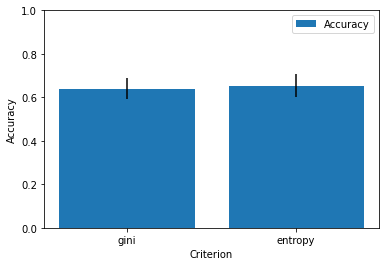

In [10]:
# Plot the relationship
plt.bar(splitting_criteria, cv_scores, yerr=cv_scores_std, label='Accuracy')
plt.xlabel('Criterion')
plt.ylim([0, 1])
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

**It can be seen that the difference between these two criteria is visually significant for this data set.**

### Task1. Parameter tuning on tree depth
During the construction process, a decision tree usually keeps growing until all leaves are pure, which leads to models that are very complex and highly overfit to the training data. The
presence of pure leaves mean that a tree is 100% accurate on the training set. Each
data point in the training set is in a leaf that has the correct majority class.

There are two common strategies to prevent overfitting: stopping the creation of the
tree early (also called pre-pruning), or building the tree but then removing or collapsing
nodes that contain little information (also called post-pruning or just pruning).
Possible criteria for pre-pruning include limiting the maximum depth of the tree,
limiting the maximum number of leaves, or requiring a minimum number of points
in a node to keep splitting it. Scikit-learn only implements pre-pruning, not
post-pruning.

In this task, you are required to use 10-cross validation to study how the testing accuarach changes w.r.t. the depth of the decision tree, i.e., the parameter 'max_depth'. Let the 'max_depth' parameter take values from the range [1, 20]. Then plot the relationship between 'max_depth' and the testing accuracy from 10 cross validation. Then, briefly describe the changes of the curve and explain why. The 'random_state' parameter for DecisionTreeClassifier is 'random_state=42'.

In [32]:
# Your code here ...
# For each tree depth, we use 10-fold cross validation to report the testing accuracy.
# For each criterion, we use 10-fold cross validation to report the testing accuracy.
cv_scores = []
cv_scores_std = []
for i in range(1, 21):
    clf_dtc = DecisionTreeClassifier(max_depth=i, random_state=42)
    scores = cross_val_score(clf_dtc, X, y, scoring='accuracy', cv=KFold(n_splits=10, shuffle=True, random_state=42))
    cv_scores.append(scores.mean())
    cv_scores_std.append(scores.std())

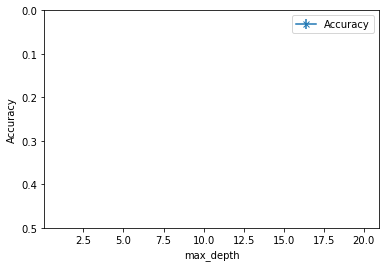

In [38]:
# Your code here ...
# Plot the relationship
# Plot the relationship
plt.errorbar(range(1, 21), cv_scores, yerr=cv_scores_std, marker='x', label='Accuracy')
plt.xlabel('max_depth')
plt.ylim([0.5, 0.])
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

**Answer to Task1:** 

### 3. Decision tree for regression
As we discussed in the lecture, the decision tree models can also handle the regression problems when the target attribute is continous. Following is a synthetic data set used for demoing the regression decision tree model.

**Generate a 1-dimensional synthetic dataset.** The data is combination of two 'sin' functions and the Gausssian noise.

In [39]:
# Generate a 1-dimensional synthetic dataset. The data is combination of two 'sin' functions and the Gausssian noise.
rng = np.random.RandomState(1)
X = np.linspace(0, 6, 100)[:, np.newaxis]
y = np.sin(X).ravel() + np.sin(2 * X).ravel() + rng.normal(0, 0.5, X.shape[0])

**Visualize the synthetic data.**

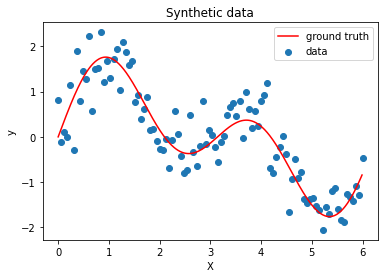

In [40]:
# Visualize the data and the ground truth
x_truth = np.arange(0, 6, 0.01)
y_truth = np.sin(x_truth)+np.sin(2*x_truth)

plt.plot(x_truth, y_truth, color='red', label='ground truth')
plt.scatter(X, y, label='data')

plt.xlabel('X')
plt.ylabel('y')
plt.title('Synthetic data')
plt.legend(loc='best')
plt.show()

**Train a regression model with tree depth 4**

In [41]:
# Split data into training and testing data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
# Training a regression tree with max_depth=4.
regressor = DecisionTreeRegressor(random_state=42, max_depth=4)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=4, random_state=42)

**Visualize the tree structure**

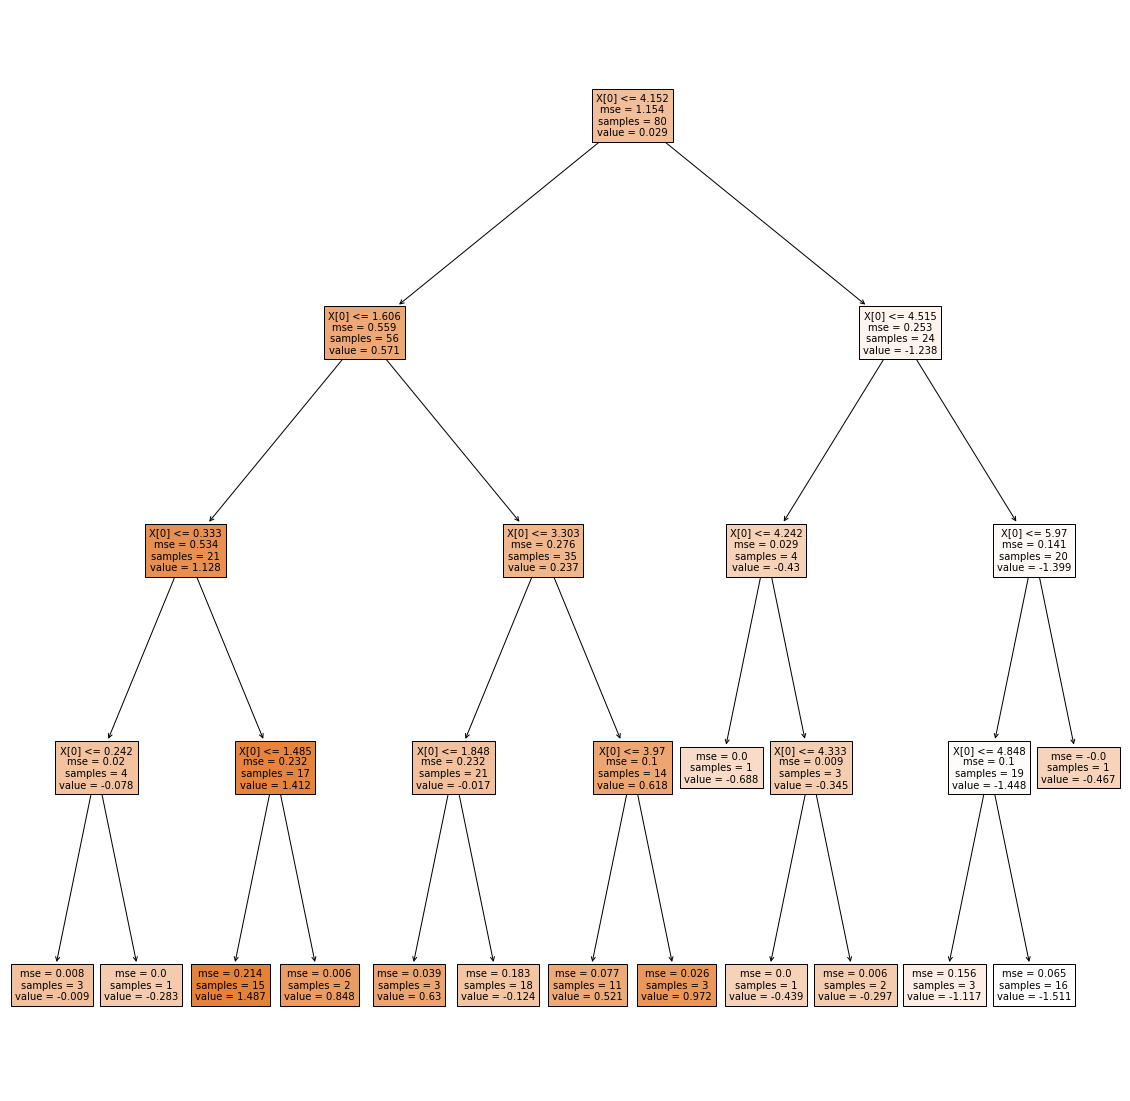

In [17]:
# Visualize the tree structure.
fig, ax = plt.subplots(figsize=(20, 20))
tree.plot_tree(regressor, filled=True, fontsize=10)
plt.show()

**Plot the learned regression model.** As we discussed in the lecture, this will be a piecewise linear regression model (each piece is the simpliest model $y=w_0$).

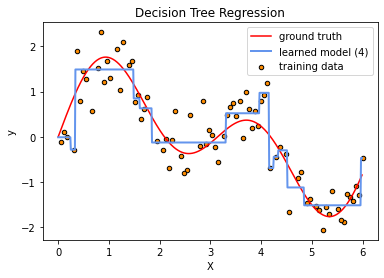

In [18]:
# Plot the learned model
x_truth = np.arange(0, 6, 0.01)
y_truth = np.sin(x_truth)+np.sin(2*x_truth)

X_model = np.arange(0.0, 6.0, 0.01)[:, np.newaxis]
y_model = regressor.predict(X_model)

plt.plot(x_truth, y_truth, color='red', label='ground truth')
plt.scatter(X_train, y_train, s=20, edgecolor="black", c="darkorange", label="training data")
plt.plot(X_model, y_model, color="cornflowerblue", label="learned model (4)", linewidth=2)

plt.xlabel("X")
plt.ylabel("y")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

In [ ]:
# model is over fitting. not under fitting.

**Evaluate the model with testing data.** We use the r2 score and the mean squared error to measure the regression performance.

In [19]:
# Evaluate the model with the testing data
y_pred = regressor.predict(X_test)
score = r2_score(y_pred, y_test)
print("\nThe r2 score is: %.4f\n" % score)


mse_test = mean_squared_error(y_pred, y_test)
mse_train = mean_squared_error(regressor.predict(X_train), y_train)
print("The mean squared error (testing) is: %.4f\n" % mse_test)
print("The mean squared error (training) is: %.4f\n" % mse_train)


The r2 score is: 0.7653

The mean squared error (testing) is: 0.2123

The mean squared error (training) is: 0.1138



In [ ]:
# model is over fitting. not under fitting. big diference 

### Task 2. Build a tree regression model with max_depth=8
In this task, you are required to build a tree regression model with tree depth being 8 and compare with the max_depth=4 case. You need to plot the learned model for visualization, tegother with the plot of the ground truth curve, training data, and the max_depth=4 case for visual comparison. 

Report the r2 score, testing, and training error, as well as a paragraph briefly discussing which model (max_depth 4 vs 8) is overfitting and why based on the performance results and visual comparison.

In [43]:
# Your code here ...
# Training a regression tree with max_depth=8.
# Training a regression tree with max_depth=4.
regressor = DecisionTreeRegressor(random_state=42, max_depth=8)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=8, random_state=42)

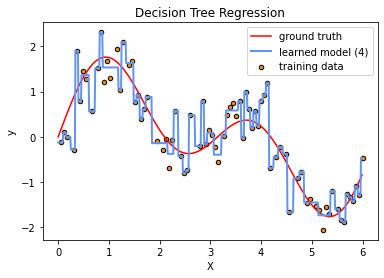

In [44]:
# Your code here ...
# Plot the learned model, tegether with the ground truth curve, training data, and the max_depth=4 case
# Plot the learned model
x_truth = np.arange(0, 6, 0.01)
y_truth = np.sin(x_truth)+np.sin(2*x_truth)

X_model = np.arange(0.0, 6.0, 0.01)[:, np.newaxis]
y_model = regressor.predict(X_model)

plt.plot(x_truth, y_truth, color='red', label='ground truth')
plt.scatter(X_train, y_train, s=20, edgecolor="black", c="darkorange", label="training data")
plt.plot(X_model, y_model, color="cornflowerblue", label="learned model (4)", linewidth=2)

plt.xlabel("X")
plt.ylabel("y")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

In [45]:
# Your code here ...
# Evaluate the model with the testing data, using the metrics r2, testing mse, and training mse.
# Evaluate the model with the testing data
y_pred = regressor.predict(X_test)
score = r2_score(y_pred, y_test)
print("\nThe r2 score is: %.4f\n" % score)


mse_test = mean_squared_error(y_pred, y_test)
mse_train = mean_squared_error(regressor.predict(X_train), y_train)
print("The mean squared error (testing) is: %.4f\n" % mse_test)
print("The mean squared error (training) is: %.4f\n" % mse_train)


The r2 score is: 0.5921

The mean squared error (testing) is: 0.3464

The mean squared error (training) is: 0.0108



**Answer to Task 2:**


## Compare with other models
Here we explore countinous features for the classification decision tree model. Another Breast Cancer data set [Wisconsin Diagnostic Breast Cancer](http://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+%28diagnostic%29) with all continous features is used. Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. The breast cancer dataset is a classic and very easy binary classification dataset. This data set is a built-in data in sklearn, and can be loaded by [load_breast_cancer](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer).

In [46]:
# Load the sklearn built-in data set.

from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

print("\nFeatures: \n", cancer.feature_names)
print("\nTarget: \n", cancer.target_names)

X = cancer.data
print("\nData size: \n", X.shape)

y = cancer.target


Features: 
 ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']

Target: 
 ['malignant' 'benign']

Data size: 
 (569, 30)


### Task 3. Comparison with the logistic regression model
Training a decision tree classifier with default parameters (random_state==42) and a logistic regression model, and report their prediction accuracies using 10-fold cross validation. Compare their accuracy scores and use t test to show if their perofrmance has siginficantly different with significance level 0.05.

In [24]:
# Your code here ...
# Use 10-fold cross validation to report the accuracy scores for comparison.
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
lr_scores= 

**Answer to Task 3:** 
